# Power Law Residual Ratio (PLRR) - v1.0 yfinance
Author: Ashwin x.com/@math_sci_tech \
Original X post: https://x.com/math_sci_tech/status/1831083600516911566

## Description
Determine the PLRR indicator using daily (Close) price bitcoin data obtained from the yfinance python library. 

**_NOTE:_** yfinance does not have full bitcoin price history. Presently, it only has it up to mid 2014.

In the orginal post, there is a dicrepency in the scaling between the formula and the chart. In order to distinguish the two, I will henceforth refer to the formula as $PLRR_{S1}$ (S here stands for scale) and the one applied in the chart as $PLRR_{S2}$.

Given:
* $k$ - Power law exponent
* $T$ - period in days over which PLRR is calculated
* $t$ - time measured in days in genesis block
* $R(t)$ - daily log price returns at $t$
* $R_{avg}(t)$ - daily log returns averaged from $t-T+1$ to $t$ 
* $R_{tot}(t)$ - total log returns = $R_{avg}(t)T$
* $\sigma(t)$ - standard deviation of $R(t)$ from $t-T+1$ to $t$ 
* $\sigma_T(t)$ - volatility = $\sigma(t)\sqrt{T}$
* $r$ - Risk free return over period $T$

Define:
$$ PLRR_{S1} = \frac{R_{tot}-k\log(1+\frac{T}{t}) - r}{\sigma_T} $$
$$ PLRR_{S2} = 100\cdot\frac{R_{avg}-\frac{1}{T}k\log(1+\frac{T}{t}) - \frac{1}{T}r}{\sigma} $$

$$ PLRR_{S1} = \frac{\sqrt{T}}{100}PLRR_{S2} $$

**_NOTE:_** $PLRR_{S1}$ definition is prefferable to $PLRR_{S2}$ since the former is always roughly bounded in (-3,+3) regardless of the choice of $T$. I will therefore phase out $PLRR_{S2}$ in favor of $PLRR_{S1}$. Alternatively, I might also propose to scale $PLRR_{S1}$ such that it is bounded in (-1,+1).
## References

[1] https://x.com/Giovann35084111/status/1832129338889924960 \
[2] https://x.com/Sina_21st/status/1800713784807264431




In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors


# Set parameters --------------
t0 = '2009-01-03' # Bitcoin genesis date
start_date = '2014-06-01' # Start date for retrieving price data
end_date = datetime.today().strftime('%Y-%m-%d') # End date for retrieving price data
k_PL = 5.7 # Power Law Exponent
T_span = 365  # Time span in days for calculating PLRR
risk_free_return = 0  # Annualized risk free return rate in percentage 

price_type = 'Close'  # Options: High, Low, Open, Close, Adj Close
ticker_name = 'BTC-USD' # ticker name for bitcoin price



# Get bitcoin price from yahoo finance -----------------------
price_df = yf.download(ticker_name, start=start_date, end=end_date)[[price_type]].copy()
# Convert t0 to datetime
t0_datetime = pd.to_datetime(t0)


# Calculate timeDays by subtracting t0 from the index
price_df['TimeDays'] = (price_df.index - t0_datetime).days
# Calculate daily log Return
price_df['LogReturn'] = np.log(price_df[price_type]).diff()
# Calculate daily log time difference
price_df['LogTimeDiff'] = np.log(price_df['TimeDays']).diff()
# Calculate rolling mean to log Return
price_df['MeanLogReturn'] = price_df['LogReturn'].rolling(T_span).mean()
# Apply rolling mean to log time difference
price_df['MeanLogTimeDiff'] = price_df['LogTimeDiff'].rolling(T_span).mean()
# Calculate rolling standard deviation
price_df['LogSDev'] = price_df['LogReturn'].rolling(T_span).std()

# Calculate Power Law Residual Ratio with scaling definition 1 (PLRR_Scale1)
price_df['PLRR_Scale1'] = np.sqrt(T_span)*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'] - (1/365)*np.log(1+risk_free_return/100))/price_df['LogSDev']

# Calculate Power Law Residual Ratio with scaling definition 1 (PLRR_Scale2)
price_df['PLRR_Scale2'] = 100*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'] - (1/365)*np.log(1+risk_free_return/100))/price_df['LogSDev']


# print(price_df)

/Users/ashwinsridhar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ashwinsridhar/Library/Python/3.9/lib/python/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


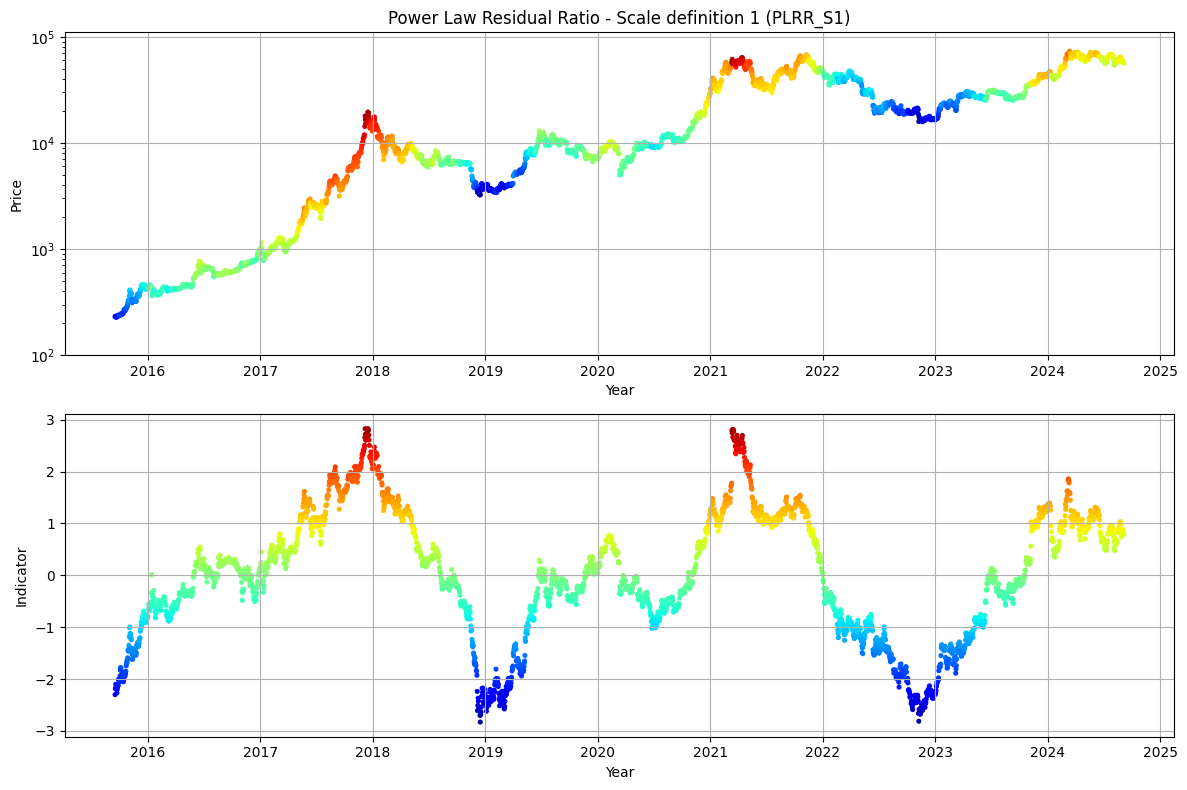

In [2]:

# Normalize the color map
norm = mcolors.Normalize(vmin=-3, vmax=3)
cmap = plt.get_cmap('jet')



# Apply color gradient
colors = cmap(norm((price_df['PLRR_Scale1'])))
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.title('Power Law Residual Ratio - Scale definition 1 (PLRR_S1)')
plt.scatter(price_df.index[T_span:],price_df[price_type][T_span:], c=colors[T_span:], s=7)
plt.yscale('log')
plt.ylim([10**2,1.1*10**5])
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Price')

plt.subplot(212)
plt.scatter(price_df.index, price_df['PLRR_Scale1'], c=colors, s=7)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Indicator')
plt.tight_layout()
plt.show()


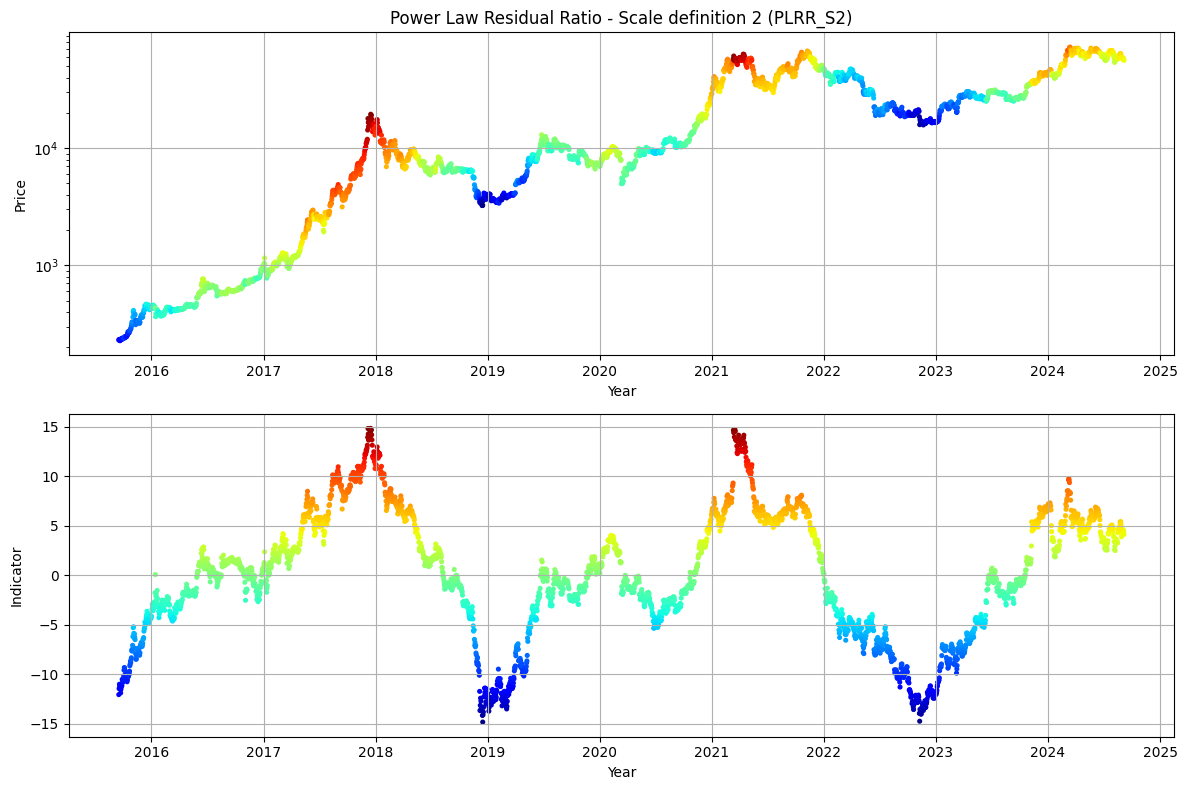

In [3]:

# Normalize the color map
norm = mcolors.Normalize(vmin=-15, vmax=15)
cmap = plt.get_cmap('jet')



# Apply color gradient
colors = cmap(norm((price_df['PLRR_Scale2'])))
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.title('Power Law Residual Ratio - Scale definition 2 (PLRR_S2)')
plt.scatter(price_df.index[T_span:],price_df[price_type][T_span:], c=colors[T_span:], s=7)
plt.yscale('log')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Price')

plt.subplot(212)
plt.scatter(price_df.index, price_df['PLRR_Scale2'], c=colors, s=7)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Indicator')
plt.tight_layout()
plt.show()
